# Time Series Modeling Project: Store Item Demand Forecasting

### Project Overview
In this project, we will build a time series forecasting model using data from the [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview).

### Objective
Given 5 years of sales data for various items across different stores, our goal is to predict daily sales for each item-store pair in the upcoming month. Accurate demand forecasting at this granular level will help stores manage inventory efficiently and avoid stockouts or overstock situations.

### Evaluation Metric
To assess model performance, we will use the **Mean Absolute Percentage Error (MAPE)**, a widely-used metric for evaluating forecasting accuracy.

### Dataset Description

The dataset includes the following attributes:

- **date**: Date of the sale data. There are no holiday effects or store closures
- **store**: Store ID
- **item**: Item ID
- **sales**: Number of items sold at a particular store onplace=True)
display(data.head())


# Project Structure
- [Data Loading and Transformation](#Data-Loading-and-Transformation)
- [Exploratory Data Analysis (EDA)](#Eda)
- [Time Series Decomposition](#Time-Series-Decomposition)
- [Autocorrelation and important lags](#Autocorrelation-and-important-lags)
- [Feature Engineering and Model Training](#Feature-Engineering-and-Model-Training)
- [Model Selection and Evaluation](#Model-Selection-and-Evaluation)
- [Backtesting](#Backtesting)
- [Conclusion](#Conclusion)


## <a id="Data-Loading-and-Transformation">Data Loading and Transformation</a>

In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

data = pd.read_csv("train.csv.zip")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
display(data.head())


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


##<a id="Eda">Exploratory Data Analysis (EDA)</a>

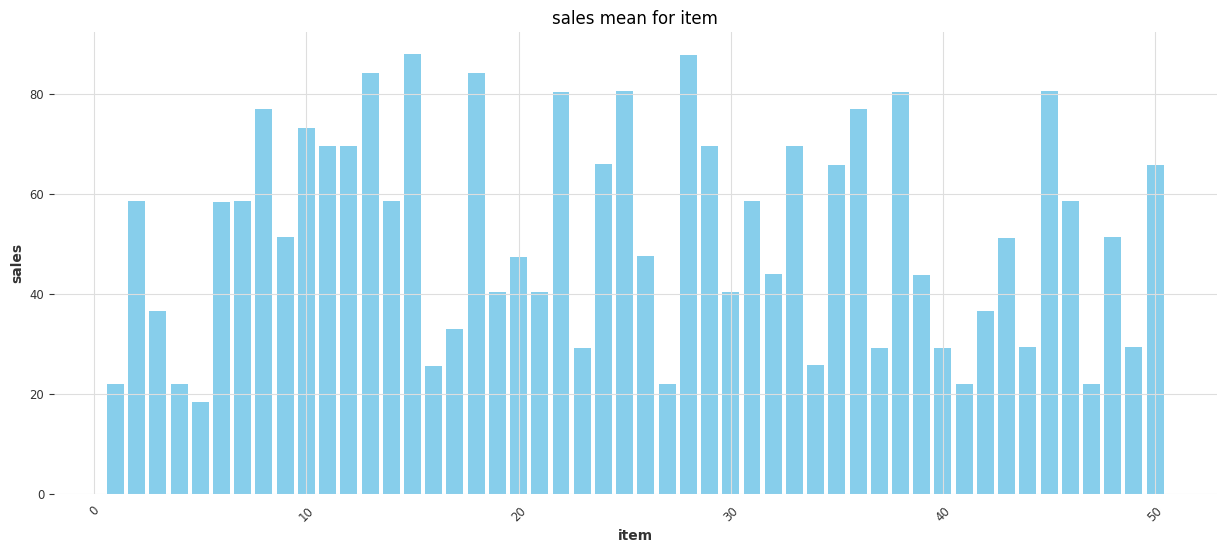

In [22]:
grouped_df = data.groupby(['item'])['sales'].mean().reset_index()
plt.figure(figsize=(15, 6))
plt.bar(grouped_df['item'], grouped_df['sales'], color='skyblue')
plt.xlabel('item')
plt.ylabel('sales')
plt.title(f"sales mean for item")
plt.xticks(rotation=45)
plt.show()

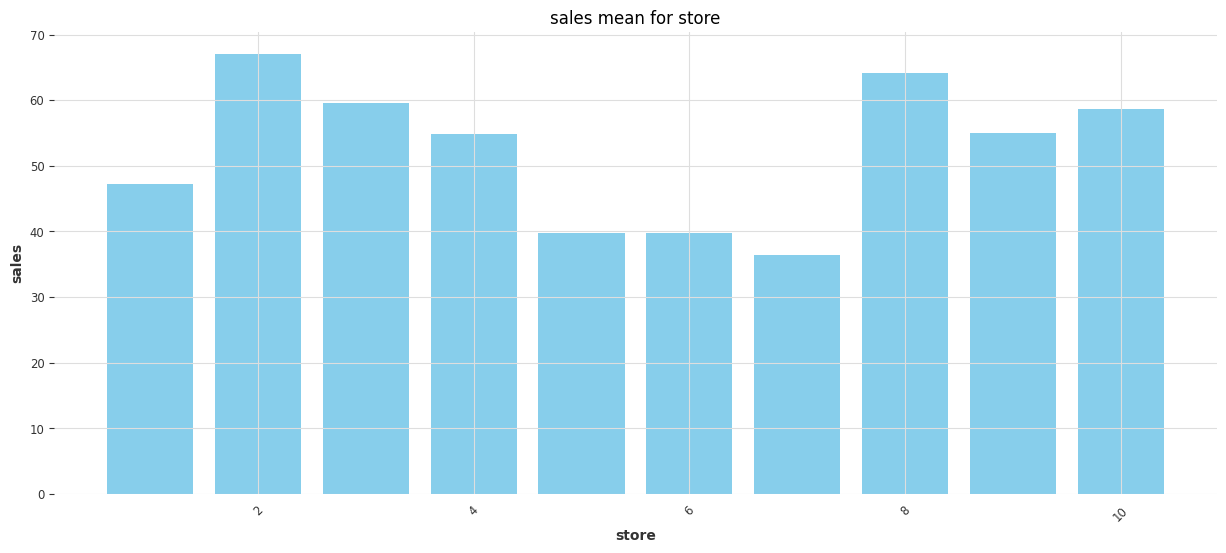

In [23]:
grouped_df = data.groupby(['store'])['sales'].mean().reset_index()
plt.figure(figsize=(15, 6))
plt.bar(grouped_df['store'], grouped_df['sales'], color='skyblue')
plt.xlabel('store')
plt.ylabel('sales')
plt.title(f"sales mean for store")
plt.xticks(rotation=45)
plt.show()

**Observations**
- The average sales vary significantly between different items and stores.
- Items with consistently low sales perform similarly across all stores, while popular items show high sales in all stores.

## <a id="Time-Series-Decomposition">Time Series Decomposition</a>

### Select Subset and Decompose


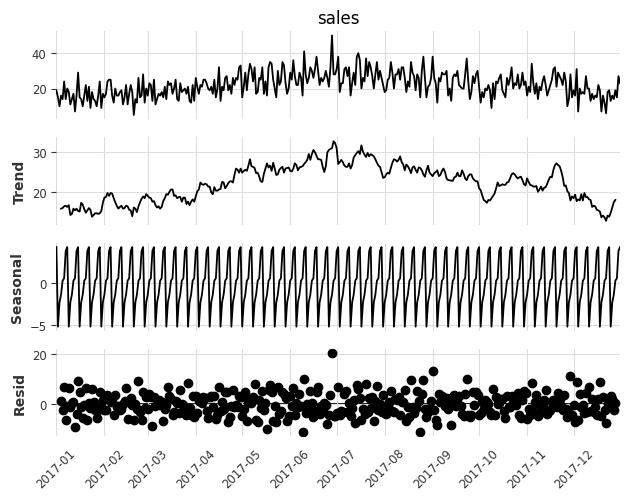

In [24]:
df_1 = data[(data['store'] == 1) & (data['item'] == 1)]
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_plot_multi = seasonal_decompose(df_1[df_1.index.year == 2017]['sales'], model='additive')
decomposition_plot_multi.plot()
plt.xticks(rotation=45)
plt.show()

**Insights**
Seasonal decomposition shows trends, seasonality, and residual components, which will help in further feature engineering and model selection.

## <a id="Autocorrelation-and-important-lags">Autocorrelation and important lags</a>

<Figure size 1000x600 with 0 Axes>

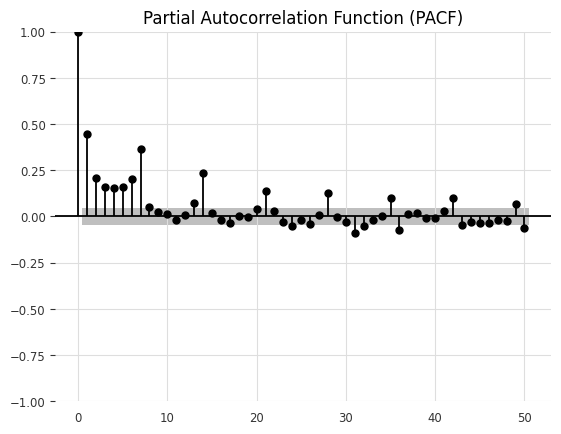

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

# Visualisation of the partial autocorrelation function (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(series.values(), lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

**Observations**.
- Significant are lags 1 to 8, as well as 14, 15, 22, 25, 29, 32, 33, 36, 37, 43, 49, 50. The correlation at these lags remains significant even after removing the influence of intermediate lags.

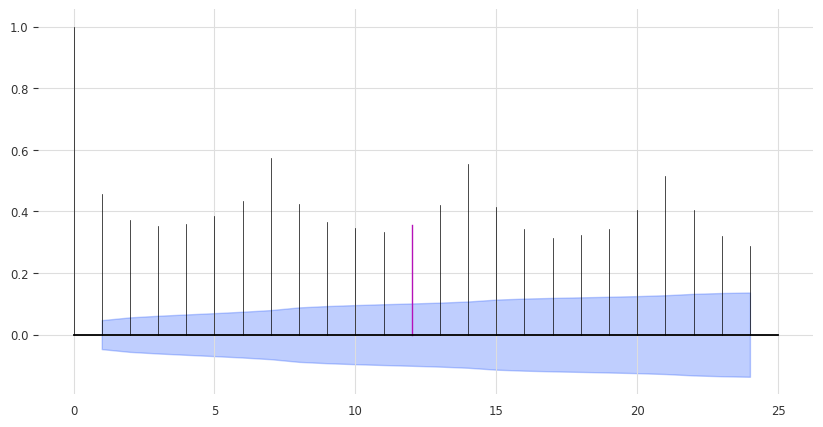

In [26]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)

**Detection of seasonality**.
- The ACF shows a peak at x = 7, 14 and 21, which indicates a seasonality of once every 7 months, which can be said to be a semi-annual seasonality

## <a id="Feature-Engineering-and-Model-Training">Feature Engineering and Model Training</a>

### Transform Data for darts

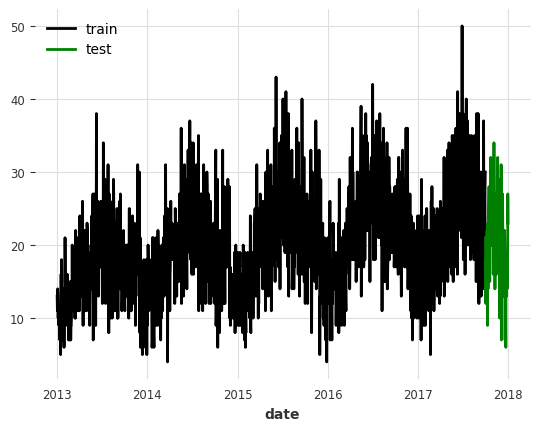

In [27]:
from darts import TimeSeries

series = TimeSeries.from_dataframe(df_1, value_cols='sales')
train, test = series.split_before(pd.Timestamp('2017-10-01'))

train.plot(label='train')
test.plot(label='test', color='green')
plt.legend()
plt.show()

**Observations**
- Split data into training and testing sets for the year 2017.
- Initial visualization provides an understanding of training and testing data trends.

## <a id="Model-Selection-and-Evaluation">Model Selection and Evaluation</a>

### XGBoost Model with Custom Feature Engineering

In [28]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

def enrich_with_date_features(df):
    df["dayofweek"] = df['date'].dt.dayofweek
    df["quarter"] = df['date'].dt.quarter
    df["month"] = df['date'].dt.month
    df["year"] = df['date'].dt.year
    df["dayofyear"] = df['date'].dt.dayofyear
    df["sin_day"] = np.sin(df["dayofyear"])
    df["cos_day"] = np.cos(df["dayofyear"])
    df["dayofmonth"] = df['date'].dt.day
    return df

train_transformed = enrich_with_date_features(train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(test.pd_dataframe().reset_index())

scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(test)

model = XGBModel(lags=7, output_chunk_length=1, n_estimators=100, max_depth=3, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8)
model.fit(train_transformed)
forecast = scaler.inverse_transform(model.predict(len(test)))


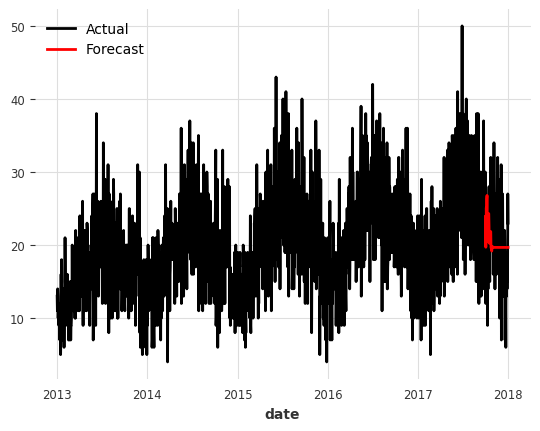

MAPE: 29.08%


In [29]:
from darts.metrics import mape
series.plot(label='Actual')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.show()
print(f"MAPE: {mape(test, forecast):.2f}%")

**Insights**
- Using XGBoost, enriched with time-based features, we observed a MAPE score of 29.08%, showing a moderate predictive accuracy on our test set.

### Exponential Smoothing Model

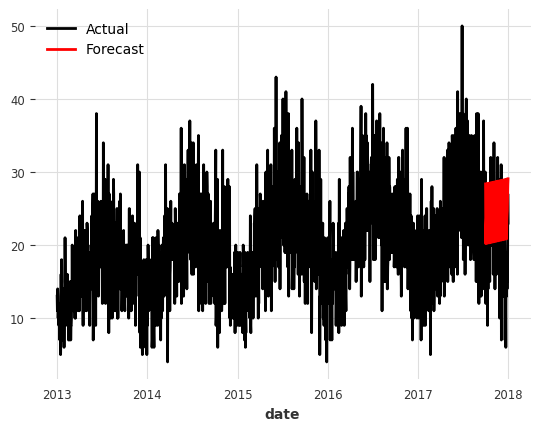

model ExponentialSmoothing() obtains MAPE: 39.01%


In [30]:
from darts.models import ExponentialSmoothing, AutoARIMA, Theta

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")

def plot_results(series, forecast):
  # Візуалізація результатів
  series.plot(label='Actual')
  forecast.plot(label='Forecast', color='red')
  plt.legend()
  plt.show()

def fit_and_plot(model, series, train, val):
  model.fit(train)
  forecast = model.predict(len(val))
  plot_results(series, forecast)
  eval_forecast(model, val, forecast);

model = ExponentialSmoothing()
fit_and_plot(model, series, train, test)

**Observations**
- Exponential Smoothing provided stable results, and MAPE was recorded at 39.01%, which reflects moderate forecasting quality.

### Prophet Model and RNNModel (LSTM)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy4cpwjq_/rgxmntvs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy4cpwjq_/cv0pol68.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7872', 'data', 'file=/tmp/tmpy4cpwjq_/rgxmntvs.json', 'init=/tmp/tmpy4cpwjq_/cv0pol68.json', 'output', 'file=/tmp/tmpy4cpwjq_/prophet_modeltn4wkwkh/prophet_model-20241029013103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:31:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


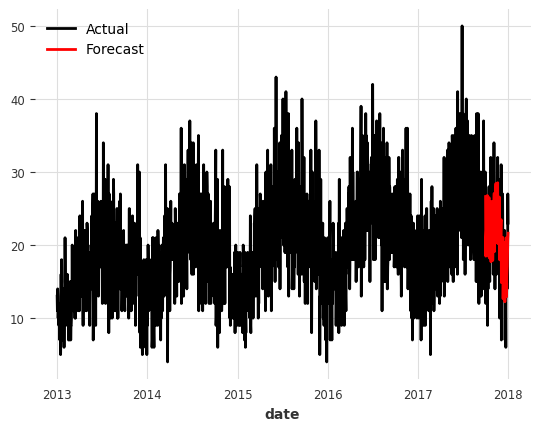

model Prophet() obtains MAPE: 23.80%


In [31]:
from darts.models import Prophet

model = Prophet()
fit_and_plot(model, series, train, test)

### RNNModel (LSTM)

In [ ]:
from darts.models import RNNModel

model = RNNModel(model='LSTM', input_chunk_length=7, n_epochs=300)
fit_and_plot(model, series, train, test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

**Summary of Results**
- The Prophet model demonstrated moderate accuracy with MAPE = 23.80%.
- The RNNModel (LSTM) model also achieved a competitive MAPE, showing potential for capturing complex seasonal patterns.

## <a id="Backtesting">Backtesting</a>

In [ ]:
model =  Prophet()
model.fit(train)
forecast = model.predict(len(test))
eval_forecast(model, test, forecast);

In [ ]:
hfc_params = {
    "series": series,
    "start": pd.Timestamp("2017-01-01"),
    "forecast_horizon": 1,
    "verbose": True,
}

historical_fcast_all = model.historical_forecasts(last_points_only=False, stride=1, **hfc_params)

series.plot(label="data")
for idx, hfc in enumerate(historical_fcast_all):
    hfc.plot(label=f"forecast {idx}")

from darts import concatenate
historical_fcast_all = concatenate(historical_fcast_all, axis=0)
print(f"MAPE = {mape(series, historical_fcast_all):.2f}%")

## <a id="Conclusion">Conclusion</a>
During backtesting, Prophet showed stable performance over one year, achieving a backtest MAPE of 20.03%.
This demonstrates the model's suitability for real-world demand forecasting and its potential value in inventory optimization.